---

## **Introduction**

### **Dynamic Programming in Grid World**

I implemented the **calculation of state values** for each position in a **grid world game** using **Dynamic Programming** in Python.

The grid world map is structured as follows:

- The game `starts` at the **Door** position.
- **Walls** are `impassable`.
- Passing through **Radiation** incurs a `penalty`.
- Reaching the **Treasure** position grants a `reward` and `ends the game.`

<img src="https://drive.google.com/uc?export=view&id=1UyixvvHu-hOYDmUtHK_ko5pjLUZWnAg1" alt="Gridworld" width="400">

---


In [138]:
import numpy as np
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

class GridWorld:
  def __init__(self, policy):
    self.policy = policy
    self.wall_map = np.array([
        ['wall',  0,     'wall',  0,     0],
        [0,       0,     0,       0,     'wall'],
        [0,       'wall', 0,      'wall', 'wall'],
        [0,       0,     0,       0,     'wall'],
        [0,       0,     0,       0,     0]])
    wall_indices = np.where(self.wall_map == 'wall')
    self.wall_cordinates = list(zip(wall_indices[0], wall_indices[1]))
    self.reward_map = np.array([
        [0, 0, 0, 0, 1],
        [-1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, -1, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ])
    self.action_mean = {
        0: 'UP',
        1: 'DOWN',
        2: 'LEFT',
        3: 'RIGHT'}
    self.action_move = {
        0: (-1, 0),
        1: (+1, 0),
        2: (0, -1),
        3: (0, +1)}
    self.action_arrows = {0: '↑', 1: '↓', 2: '←', 3: '→', -1: '↔↕'}
    self.start_state = np.array([4, 0])
    self.value_map = np.zeros(shape = (5, 5))
    self.terminal_state = (0, 4)
    self.grid_limit = (self.height - 1, self.width - 1)
    self.gamma = 0.9

  def policy_eval(self):
    for y in range(self.height):
      for x in range(self.width):
        if (y, x) == self.terminal_state:  # Skip terminal state
          continue
        elif (y, x) not in self.wall_cordinates:
          new_value = 0
          for action in self.policy[(y, x)]:  # Use tuple (y, x) as key
            current_state = (y, x)
            next_state = self.next_state(current_state, action)

            reward = self.reward_map[next_state]
            value = self.value_map[next_state]
            prob = self.policy[(y, x)][action]
            # Accumulate value
            new_value += prob * (reward + self.gamma * value)

          self.value_map[y, x] = new_value


  def next_state(self, current_state, action):
    (y, x) = current_state
    (dy, dx) = self.action_move[action]
    next_state = (y + dy, x + dx)
    next_state = (
        max(0, min(self.grid_limit[0], next_state[0])),
        max(0, min(self.grid_limit[1], next_state[1])))
    if next_state in self.wall_cordinates:  # If the next state is a wall, stay in the current state
      next_state = current_state
    return next_state


  def render(self, policy_show=True):
    plt.figure(figsize=(10, 8))
    """
    Visualize the grid world with value function and optional policy arrows
    """
    vmin = np.min(self.value_map)
    vmax = np.max(self.value_map)
    colors = ["red", "white", "green"]  # 빨강-흰색-초록
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    plt.pcolormesh(np.flipud(self.value_map), cmap=custom_cmap, vmin=vmin, vmax=vmax, alpha=0.8)

    for y in range(self.height):
      for x in range(self.width):
        if (y, x) in self.wall_cordinates:
          plt.text(
                x + 0.5, self.height - y - 0.5, "Wall",
                ha="center", va="center", fontsize=20, color="purple")
        else:
          if (y, x) == self.terminal_state:
            plt.text(
              x + 0.1, self.height - y - 0.1,
              "Terminal State",
              ha="left", va="top", fontsize=10, color="black")
          else:
            plt.text(
                x + 0.1, self.height - y - 0.1,
                f"Value: {self.value_map[y, x]: .4f}",
                ha="left", va="top", fontsize=10, color="black")

    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    # Add grid lines manually
    plt.gca().set_xticks(np.arange(self.width + 1), minor=True)
    plt.gca().set_yticks(np.arange(self.height + 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.7)

    plt.title("GridWorld Map, State Value under Random Policy", fontsize=16)
    plt.show()

  @property
  def height(self):
    return self.reward_map.shape[0]

  @property
  def width(self):
    return self.reward_map.shape[1]

Number of update: 51


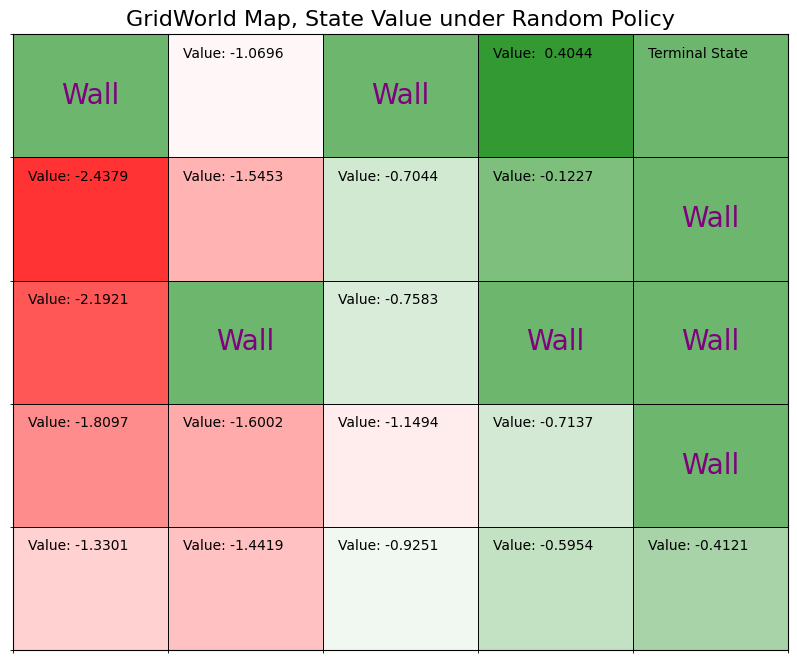

In [141]:
from collections import defaultdict
random_policy = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})

game = GridWorld(random_policy)

count = 0
while True:
  past_v = game.value_map.copy()
  game.policy_eval()
  count += 1
  current_v = game.value_map.copy()
  delta = np.max(np.abs(past_v - current_v))
  if delta < 1e-4:
    break
print(f'Number of update: {count}')
game.render()

---

## **Conclusion**

The results above were obtained after a total of **51 updates**. These represent the **state values** under a **random policy**, where actions (up, down, left, right) are selected with equal probability regardless of the state.

**An interesting observation** is the point at **`[4, 2]`** (using NumPy indexing), where the **Value = -0.9251**. To reach the goal from this point, one must pass through **`[3, 2]`** (Value = -1.1494), which has a smaller state value than **`[4, 2]`**. This is because there is a **25% chance of incurring a penalty** at this location.

Therefore, relying solely on **state values** may not be sufficient to find the **optimal policy**. It is necessary to also consider **action values**.

---